### Load Data

In [1]:
model_name = 'model_siamese_baseline_large_norm'
num_epochs = 50

In [2]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader
from torch_geometric.loader import DataLoader 
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool, global_add_pool
from torch_geometric.utils import dense_to_sparse
import math
import numpy as np

In [3]:
data_dir_1 = 'C:/Users/david/pyproj/pyg/adl/patch_label_1'
data_dir_0 = 'C:/Users/david/pyproj/pyg/adl/patch_label_0'
#data_dir_1 = 'adl_data_1'
#data_dir_0 = 'adl_data_0'

In [4]:
from c_PatchDataset_sparse import PatchDataset
dataset = PatchDataset(data_dir_label_0 = data_dir_0,  data_dir_label_1=data_dir_1,  neg_pos_ratio=1)
len(dataset)

572

In [5]:
print(f'Number of graphs pairs: {len(dataset)}')
data = dataset[0]  # Get the first graph object.
print(data)

Number of graphs pairs: 572
(Data(x=[100, 3], edge_index=[2, 606], y=1), Data(x=[100, 3], edge_index=[2, 614], y=1))


In [6]:
graph_dataset= []
for data in dataset:
    graph_dataset.append(data[0])
    graph_dataset.append(data[1])

In [7]:
from torch_geometric.data import Data

pair_data = []
couple_loader = DataLoader(dataset = graph_dataset, batch_size=2, shuffle=False)

for couple in couple_loader:
    y = couple.y[0].long()
    couple_graph = Data(x=couple.x, edge_index=couple.edge_index, y=y, original_batch = couple.batch)
    pair_data.append(couple_graph)

In [8]:
batch_size = 1

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(pair_data, [n_train, n_val, n_test])
print(f'Number of training graphs pairs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs pairs: 382
Number of validation graphs: 95
Number of test graphs: 95


In [9]:
databatch = next(iter(train_loader))
databatch

DataBatch(x=[200, 3], edge_index=[2, 1266], y=[1], original_batch=[200], batch=[200], ptr=[2])

In [10]:
databatch.original_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

### Define Loss Function

In [11]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):

        diff = x0 - x1
        pow = torch.pow(diff, 2)
        dist_sq = torch.sum(pow, 0)
        dist = torch.sqrt(dist_sq) 
        mdist = self.margin - dist #negative euclidean distance - margin
        dist_marg = torch.clamp(mdist, min=0.0) # only distances <margin will be still positive here
        loss =  y * torch.pow(dist, 2) + (1-y) * torch.pow(dist_marg,2)
        
        #             Margin = 1            Margin = 2.0        Margin = 3.0
        # dist = 0.2  label 1 --> 0.04      --> 0.04            --> 0.04
        # dist = 0.2  label 0 --> 0.64      --> 3.24            --> 7.84
        #
        # dist = 0.5  label 1 --> 0.25      --> 0.25            --> 0.25
        # dist = 0.5  label 0 --> 0.25      --> 2.25            --> 6.25
        # 
        # dist = 1.0  label 1 --> 1.0       --> 1.0             --> 1.0 
        # dist = 1.0  label 0 --> 0         --> 1.0             --> 4.0
        #
        # dist = 1.5  label 1 --> 2.25      --> 2.25            --> 2.25
        # dist = 1.5  label 0 --> 0         --> 0.25            --> 2.25
        # 
        # dist = 3    label 1 --> 9         --> 9               --> 9
        # dist = 3    label 0 --> 0         --> 0               --> 0

        loss = loss / 2.0
        return loss

### Define Network

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

               
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, normalize)
        self.conv3 = GCNConv(hidden_channels, out_channels, normalize)


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)

        return x


class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.gnn1 = GNN(dataset.num_features, 8, 16)
        self.gnn2 = GNN(16, 32, 64, lin=False)
        self.gnn3 = GNN(64, 96, 128, lin=False)

        self.lin1 = torch.nn.Linear(128, 256) 
        self.lin2 = torch.nn.Linear(256, 384)


    def forward(self, x, adj, batch):
        
        x = self.gnn1(x, adj)
        x = self.gnn2(x, adj)
        x = self.gnn3(x, adj)

        #x = global_max_pool(x, batch)
        x = global_mean_pool(x, batch)
        #x = global_add_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))

        return x

In [13]:
def count_parameters(model, trainable=True):
    return sum(p.numel() for p in model.parameters() if p.requires_grad or not trainable)

### Training

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ConvNet().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.original_batch)
        
        # Contrastive Loss
        loss_contrastive = 0
        # Iterate over the pairs in one batch and compute the loss for each pair
        for j, i in enumerate(range(0, output.shape[0], 2)):
            loss = criterion(output[i], output[i+1], data.y[j])
            loss_contrastive += loss
        loss_contrastive = loss_contrastive/batch_size

        loss_contrastive.backward()
        loss_all += loss_contrastive.item()
        optimizer.step()

    return loss_all# / len(train_dataset)



@torch.no_grad()
def test(loader):
    model.eval()

    distances_lab1 = []
    distances_lab0 = []
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.original_batch)

        # Contrastive Loss
        # Iterate over the pairs in one batch and compute the loss for each pair
        for j, i in enumerate(range(0, output.shape[0], 2)):
            loss = criterion(output[i], output[i+1], data.y[j])
            euclidean_distance = F.pairwise_distance(output[i], output[i+1])
            label = data.y[j]

            if int(label) == 1: 
                distances_lab1.append(float(euclidean_distance))
                loss_all += float(loss)
            else:
                distances_lab0.append(float(euclidean_distance))
                loss_all += float(loss)

    return  distances_lab0, distances_lab1, loss_all/(len(loader)*batch_size)



# Initialize data collections
#==============================================================================================================================
train_distances_lab0 = []
train_distances_lab1 = []
train_losses = []

validation_distances_lab0 = []
validation_distances_lab1 = []
validation_losses = []

test_distances_lab0 = []
test_distances_lab1 = []
test_losses = []

val_dists_0 = []
val_dists_1 = []
train_dists_0 = []
train_dists_1 = []

parameters = count_parameters(model)
with open(f'{model_name}_printout.txt', 'w') as f:
    f.write(f'Training Data ({model_name}):\n')
    f.write(f'Number of Parameters: {parameters}\n')
    f.close()
#==============================================================================================================================



# Test and Validation Data before Training
#==============================================================================================================================
train_results = test(train_loader)
train_distances_lab0.append(train_results[0])
train_distances_lab1.append(train_results[1])
train_losses.append(train_results[2])

validation_results = test(val_loader)
validation_distances_lab0.append(validation_results[0])
validation_distances_lab1.append(validation_results[1])
validation_losses.append(validation_results[2])

test_results = test(test_loader)
test_distances_lab0.append(test_results[0])
test_distances_lab1.append(test_results[1])
test_losses.append(test_results[2])

min_val_loss = (validation_results[2]+test_results[2])/2
#==============================================================================================================================



# Compute Euclidean Distances for printout
#==============================================================================================================================
val_dist_0 = test_results[0] + validation_results[0] # List of all euclidean distances of label 0 members of val and test dataset
val_dist_1 = test_results[1] + validation_results[1] # List of all euclidean distances of label 1 members of val and test dataset
# Ratio (mean label 0 euclid dist in validation set / mean label 1 euclid dist in validation set)
val_dist_ratio = (sum(val_dist_0) / len(val_dist_0)) / (sum(val_dist_1) / len(val_dist_1))
best_dist_ratio = val_dist_ratio
val_dists_0.append(sum(val_dist_0) / len(val_dist_0))
val_dists_1.append(sum(val_dist_1) / len(val_dist_1))

train_dist_0 = train_results[0] # List of all euclidean distances of label 0 members of train dataset
train_dist_1 = train_results[1] # List of all euclidean distances of label 0 members of train dataset
# Ratio of (mean label 0 euclid dist in training set / mean label 1 euclid dist in training set)
train_dist_ratio = (sum(train_dist_0) / len(train_dist_0)) / (sum(train_dist_1) / len(train_dist_1))
train_dists_0.append(sum(train_dist_0) / len(train_dist_0))
train_dists_1.append(sum(train_dist_1) / len(train_dist_1))
#===============================================================================================================================

#printout = (f'Before Tr:  Train Loss: {train_results[2]:.3f}, Val Loss: {validation_results[2]:.3f}, Test Loss: {test_results[2]:.3f}, '
#            f'ValDist 0: {val_dist_0:.3f}, ValDist 1: {val_dist_1:.3f}, TrainDist 0: {train_dist_0:.3f}, TrainDist 1: {train_dist_1:.3f}')

printout = (f'Before Tr:  Train Loss: {train_results[2]:.3f}, Val Loss: {validation_results[2]:.3f}, Test Loss: {test_results[2]:.3f}, '
            f'ValDistanceRatio (L0/L1): {(val_dist_ratio):.3f}, TrainDistanceRatio (L0/L1): {(train_dist_ratio):.3f}')

print(printout)

# append to outputs txt
with open(f'{model_name}_printout.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()



#===============================================================================================================================================
# Training
#===============================================================================================================================================

for epoch in range(1, num_epochs+1):
    train_loss = train(epoch)


    # Test and Validation Data During Training
    #===============================================================================================================================================
    train_results = test(train_loader)
    train_distances_lab0.append(train_results[0])
    train_distances_lab1.append(train_results[1])
    train_losses.append(train_results[2])

    validation_results = test(val_loader)
    validation_distances_lab0.append(validation_results[0])
    validation_distances_lab1.append(validation_results[1])
    validation_losses.append(validation_results[2])

    test_results = test(test_loader)
    test_distances_lab0.append(test_results[0])
    test_distances_lab1.append(test_results[1])
    test_losses.append(test_results[2])

    #===============================================================================================================================================



    # Compute Euclidean Distances for printout
    #==============================================================================================================================
    val_dist_0 = test_results[0]+validation_results[0] # List of all euclidean distances of label 0 members of val and test dataset
    val_dist_1 = test_results[1]+validation_results[1] # List of all euclidean distances of label 1 members of val and test dataset
    # Ratio (mean label 0 euclid dist in validation set / mean label 1 euclid dist in validation set)
    val_dist_ratio = (sum(val_dist_0) / len(val_dist_0)) / (sum(val_dist_1) / len(val_dist_1))
    val_dists_0.append(sum(val_dist_0) / len(val_dist_0))
    val_dists_1.append(sum(val_dist_1) / len(val_dist_1))

    train_dist_0 = train_results[0] # List of all euclidean distances of label 0 members of train dataset
    train_dist_1 = train_results[1] # List of all euclidean distances of label 0 members of train dataset
    # Ratio of (mean label 0 euclid dist in training set / mean label 1 euclid dist in training set)
    train_dist_ratio = (sum(train_dist_0) / len(train_dist_0)) / (sum(train_dist_1) / len(train_dist_1))
    train_dists_0.append(sum(train_dist_0) / len(train_dist_0))
    train_dists_1.append(sum(train_dist_1) / len(train_dist_1))
    #===============================================================================================================================
    


    # Create Printout
    #===============================================================================================================================================
    #printout = (f'Epoch: {epoch:03d}, Train Loss: {train_results[2]:.3f}, Val Loss: {validation_results[2]:.3f}, Test Loss: {test_results[2]:.3f}, '
    #        f'ValDist 0: {val_dist_0:.3f}, ValDist 1: {val_dist_1:.3f}, TrainDist 0: {train_dist_0:.3f}, TrainDist 1: {train_dist_1:.3f}')
    printout = (f'Epoch: {epoch:03d}, Train Loss: {train_results[2]:.3f}, Val Loss: {validation_results[2]:.3f}, Test Loss: {test_results[2]:.3f}, '
            f'ValDistanceRatio (L0/L1): {(val_dist_ratio):.3f}, TrainDistanceRatio (L0/L1): {(train_dist_ratio):.3f}')
    print(printout)

    # append to outputs txt
    with open(f'{model_name}_printout.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()
    #===============================================================================================================================================



    # Save the model outputs
    #===============================================================================================================================================
    np.save(f'{model_name}_training_loss.npy', train_losses, allow_pickle=True)
    np.save(f'{model_name}_training_distances_lab0.npy', train_distances_lab0, allow_pickle=True)
    np.save(f'{model_name}_training_distances_lab1.npy', train_distances_lab1, allow_pickle=True)

    np.save(f'{model_name}_validation_loss.npy', validation_losses, allow_pickle=True)
    np.save(f'{model_name}_validation_distances_lab0.npy', validation_distances_lab0, allow_pickle=True)
    np.save(f'{model_name}_validation_distances_lab1.npy', validation_distances_lab1, allow_pickle=True)

    np.save(f'{model_name}_test_loss.npy', test_losses, allow_pickle=True)
    np.save(f'{model_name}_test_distances_lab0.npy', test_distances_lab0, allow_pickle=True)
    np.save(f'{model_name}_test_distances_lab1.npy', test_distances_lab1, allow_pickle=True)
    
    last_saved_epoch = epoch
    #===============================================================================================================================================



    # If the epoch has improved the model, save it
    if val_dist_ratio > best_dist_ratio:
        new_best = True
        best_dist_ratio = val_dist_ratio
        best_epoch = epoch
    else:
        new_best = False
        
    if new_best:
        torch.save(model.state_dict(), f'{model_name}_state_dict_best.pt')
        torch.save(model, f'{model_name}_save.pt')
    


cpu
Before Tr:  Train Loss: 0.225, Val Loss: 0.244, Test Loss: 0.249, ValDistanceRatio (L0/L1): 1.405, TrainDistanceRatio (L0/L1): 1.443
Epoch: 001, Train Loss: 0.121, Val Loss: 0.129, Test Loss: 0.120, ValDistanceRatio (L0/L1): 1.954, TrainDistanceRatio (L0/L1): 1.944
Epoch: 002, Train Loss: 0.108, Val Loss: 0.121, Test Loss: 0.119, ValDistanceRatio (L0/L1): 1.745, TrainDistanceRatio (L0/L1): 1.773
Epoch: 003, Train Loss: 0.096, Val Loss: 0.096, Test Loss: 0.099, ValDistanceRatio (L0/L1): 1.778, TrainDistanceRatio (L0/L1): 1.765
Epoch: 004, Train Loss: 0.101, Val Loss: 0.103, Test Loss: 0.103, ValDistanceRatio (L0/L1): 2.232, TrainDistanceRatio (L0/L1): 2.051
Epoch: 005, Train Loss: 0.093, Val Loss: 0.090, Test Loss: 0.094, ValDistanceRatio (L0/L1): 2.044, TrainDistanceRatio (L0/L1): 1.908
Epoch: 006, Train Loss: 0.094, Val Loss: 0.094, Test Loss: 0.096, ValDistanceRatio (L0/L1): 1.922, TrainDistanceRatio (L0/L1): 1.897
Epoch: 007, Train Loss: 0.090, Val Loss: 0.091, Test Loss: 0.092,

### Evaluation

In [15]:
best_epoch, last_saved_epoch

(29, 50)

In [22]:
import matplotlib.pyplot as plt

def compare_euclid_distances(distances_lab0, distances_lab1, save=None):

    w = 0.8    # bar width
    x = [1, 2] # x-coordinates of your bars
    colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors

    # Epoch 0
    y = [distances_lab0, distances_lab1]


    fig, ax = plt.subplots()
    ax.bar(x,
        height=[np.mean(yi) for yi in y],
        yerr=[np.std(yi) for yi in y],    # error bars
        capsize=12, # error bar cap width in points
        width=w,    # bar width
        tick_label=["Label 0", "Label 1"],
        color=(0,0,0,0),  # face color transparent
        edgecolor=colors,
        )

    for i in range(len(x)):
        # distribute scatter randomly across whole width of bar
        ax.scatter(x[i] + np.random.random(len(y[i])) * w - w / 2, y[i], color=colors[i])

    plt.ylabel = 'Euclidean Distance'
    plt.ylim(top=1.2, bottom=0)
    
    if save != None:
        plt.savefig(save)
    plt.show()


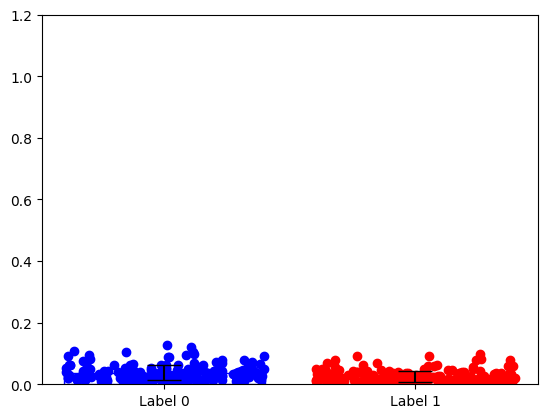

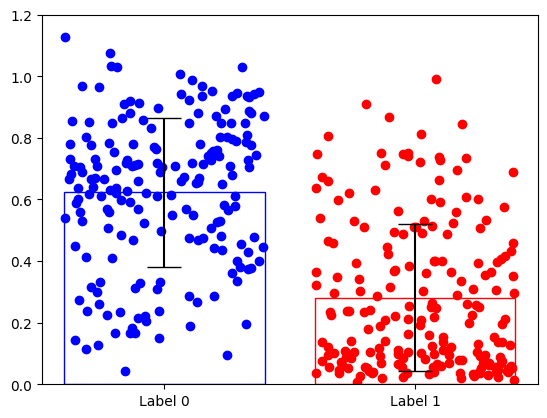

In [23]:
compare_euclid_distances(train_distances_lab0[0], train_distances_lab1[0], save = model_name + '_plot_train_dist0.png')
compare_euclid_distances(train_distances_lab0[best_epoch], train_distances_lab1[best_epoch], save = model_name + f'_plot_train_dist_{best_epoch}')

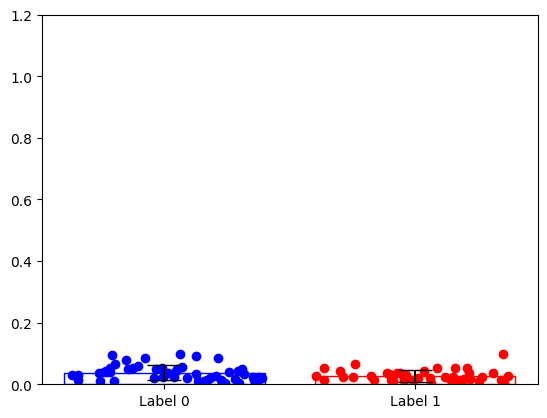

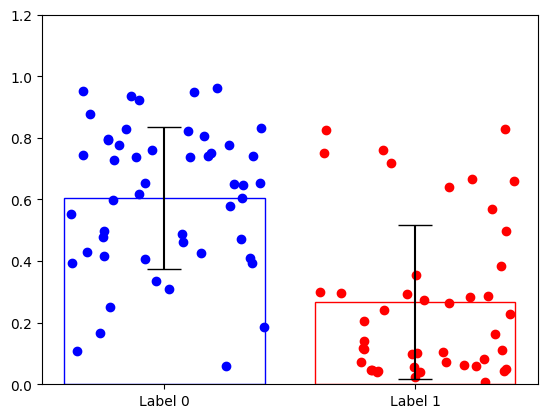

In [24]:
compare_euclid_distances(validation_distances_lab0[0], validation_distances_lab1[0], save = model_name + '_plot_val_dist0.png')
compare_euclid_distances(validation_distances_lab0[best_epoch], validation_distances_lab1[best_epoch], save = model_name + f'_plot_val_dist_{best_epoch}')

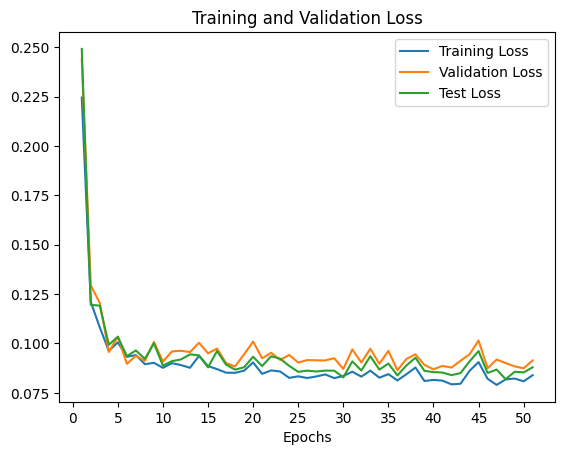

In [25]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, last_saved_epoch+2)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
 
# Set the tick locations
plt.xticks(np.arange(0, last_saved_epoch+1, last_saved_epoch/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_plot_loss.png')
#plt.ylim(top=60, bottom = 0)
plt.show()


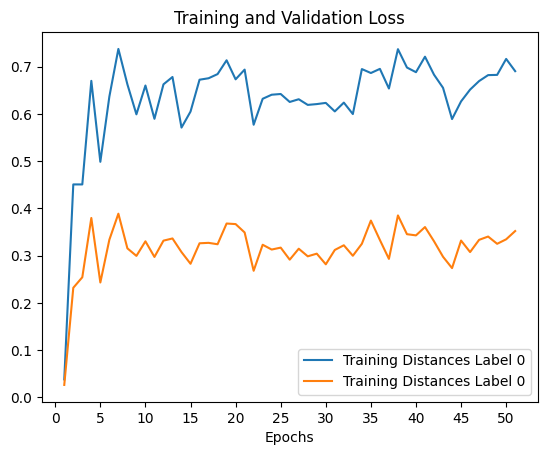

In [26]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, last_saved_epoch+2)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_dists_0, label='Training Distances Label 0')
plt.plot(epochs, train_dists_1, label='Training Distances Label 0')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
 
# Set the tick locations
plt.xticks(np.arange(0, last_saved_epoch+1, last_saved_epoch/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_plot_train_distances.png')
#plt.ylim(top=60, bottom = 0)
plt.show()

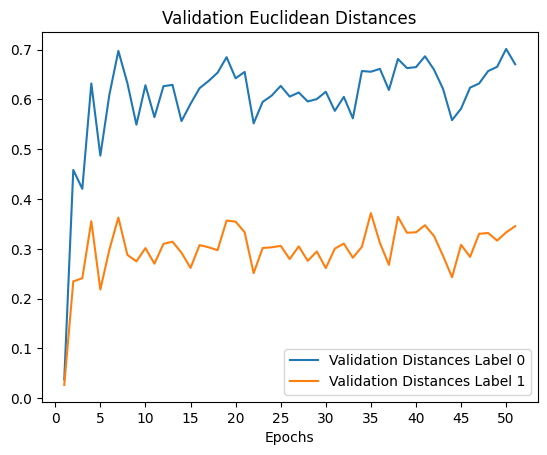

In [27]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, last_saved_epoch+2)
 
# Plot and label the training and validation loss values
plt.plot(epochs, val_dists_0, label='Validation Distances Label 0')
plt.plot(epochs, val_dists_1, label='Validation Distances Label 1')
 
# Add in a title and axes labels
plt.title('Validation Euclidean Distances')
plt.xlabel('Epochs')
 
# Set the tick locations
plt.xticks(np.arange(0, last_saved_epoch+1, last_saved_epoch/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_plot_val_distances.png')
#plt.ylim(top=60, bottom = 0)
plt.show()